# Forecasting

Source: https://github.com/gxercavins/time-series/tree/master

The best model is selected for use in the final `forecast.ipynb` file, used to predict the up-coming week results. Week 5 predictions are written to a results.xlsx file and shown below.

For context, the prediction results with the corresponding confidence interval (default 95 %) are also appended to the latest samples in the following graph.

**Next steps**
These results could possibly be improved by leveraging a more complex SARIMA model. For computational reasons, it was not feasible to explore higher-order parameter combinations. However, the best performing triplets are some of the most complex ones so this could lead me to believe there is room for improvement. Also, we can plot the model fit components from the integrated diagnostics tool:

Briefly, whilst the residuals (top-left) resemble white noise and the correlogram (bottom-right) shows no correlation with lagged samples, the quantile distribution (bottom-left) is clearly not linear and the histogram (top-right) is far from a normal distribution. The latter two conditions hint at the possibility of obtaining a better fit, too.

Also, gaining access to a larger database would mean being able to fit yearly seasonality which would require more computing resources. For clearer insights we would need more context and information about data source. If we had actual dates we could join it with a weather dataset and expect higher number of orders when the weather is not permitting.

This example was intended for an interview process (input data has been appropiately modified) so the way to evaluate the model was using test data which is not provided here. Consider splitting the input data into 3 weeks training + 1 week test if needed. Some changes would be needed for a final report, such as disallowing negative forecasted values for the confidence intervals.

In [1]:
import warnings

warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
import statsmodels.api as sm
import numpy as np

In [2]:
# load data
xl = pd.ExcelFile('input_data.xlsx')

data = {sheet_name: xl.parse(sheet_name) for sheet_name in xl.sheet_names}

res = []

for name in xl.sheet_names:
    mylist = map(list, zip(*data[name].values))
    aux = list(it.chain(*mylist))
    del aux[:24]
    res.append(aux)

res = list(it.chain(*res))

In [3]:
# train Seasonal ARIMA model
mod = sm.tsa.statespace.SARIMAX(res,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 168),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

print(round(results.aic,2))
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(15, 12))
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88043D+00    |proj g|=  7.95311D-02


 This problem is unconstrained.



At iterate    5    f=  2.87256D+00    |proj g|=  3.15409D-02

At iterate   10    f=  2.87241D+00    |proj g|=  4.18480D-03

At iterate   15    f=  2.87133D+00    |proj g|=  2.76343D-02

At iterate   20    f=  2.83605D+00    |proj g|=  6.18892D-02


KeyboardInterrupt: 

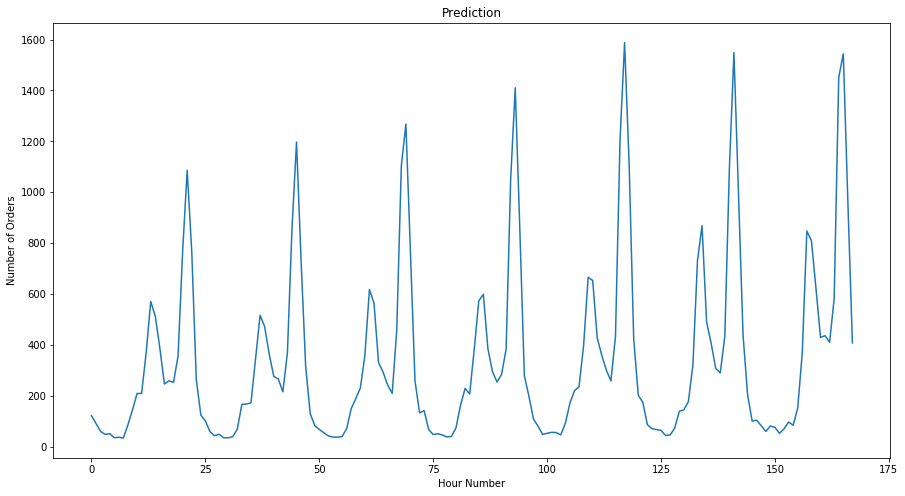

In [6]:
# Get forecast one week ahead in future
pred_uc = results.get_forecast(steps=168)

plt.rcParams['figure.figsize'] = [15, 8]

plt.plot(pred_uc.predicted_mean)
# plt.plot(res[-168:], color='red') # compare with previous week
plt.xlabel('Hour Number')
plt.ylabel('Number of Orders')
plt.title('Prediction')
plt.show()

In [7]:
# save to excel
rows = range(0,24)
cols = ['HOURS', 'MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']

df = pd.DataFrame(columns=cols,
                  index=rows)
df['HOURS'] = rows

pred_uc.predicted_mean = pred_uc.predicted_mean.astype(int)
fc = [pred_uc.predicted_mean[i:i + 24] for i in range(0, len(pred_uc.predicted_mean), 24)]

for i in enumerate(fc):
    df[cols[i[0] + 1]] = i[1]

df.to_excel('results.xlsx', sheet_name='W5', index=False)

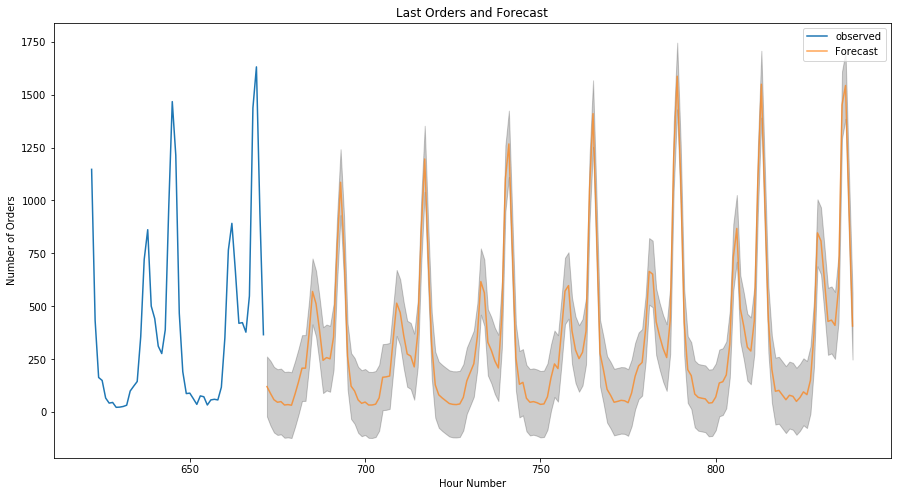

In [10]:
# plot LAST_N_SAMPLES and prediction
LAST_N_SAMPLES = 50

pred_ci = pred_uc.conf_int()

X_obs = range(0, 672)
X_pred = range(672, 840)

plt.plot(X_obs[-LAST_N_SAMPLES:], res[-LAST_N_SAMPLES:], label='observed')
plt.plot(X_pred[:168], pred_uc.predicted_mean[:168], label='Forecast', alpha=.7)

plt.fill_between(X_pred,
                pred_ci[:, 0],
                pred_ci[:, 1], color='k', alpha=.2)

plt.xlabel('Hour Number')
plt.ylabel('Number of Orders')
plt.title('Last Orders and Forecast')
plt.legend()
plt.show()

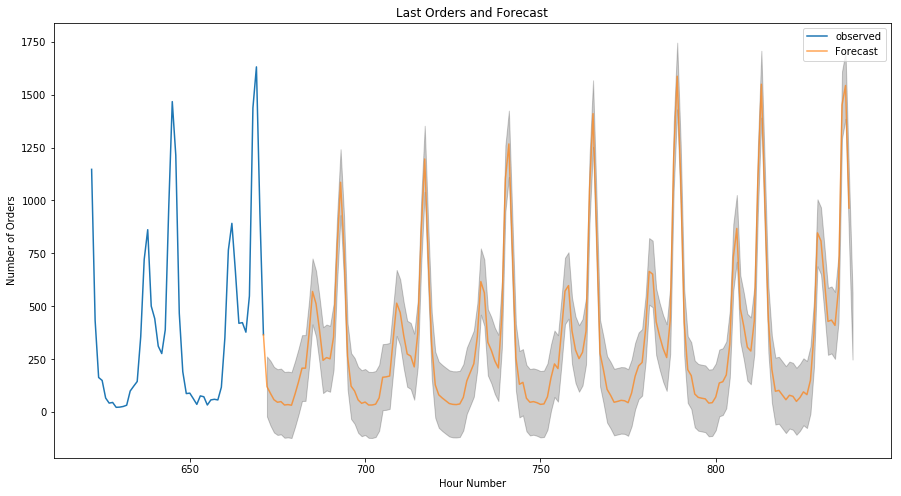

In [11]:
# add last observed value as first predicted one to avoid gap in graph

X_pred = range(671, 840) # predicted range will start one sample before

pred_uc.predicted_mean = np.insert(pred_uc.predicted_mean, 0, res[-1], axis=0) # we insert the value

plt.plot(X_obs[-LAST_N_SAMPLES:], res[-LAST_N_SAMPLES:], label='observed')
plt.plot(X_pred[:168], pred_uc.predicted_mean[:168], label='Forecast', alpha=.7)

plt.fill_between(X_pred[1:], # now we fill confidence interval starting at sample index 1
                pred_ci[:, 0],
                pred_ci[:, 1], color='k', alpha=.2)

plt.xlabel('Hour Number')
plt.ylabel('Number of Orders')
plt.title('Last Orders and Forecast')
plt.legend()
plt.show()